In [1]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss, huber_loss, ddqn_loss, vdbe_boltzmann

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
import tqdm
import matplotlib

import gym
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

%load_ext autoreload

In [2]:
sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticksplt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)

In [50]:
%autoreload

## Hyperparameters

In [57]:
NUM_RUNS = 60
num_episodes = 300
layers = [4,128,128,2]
#Loss is Huber
#reLu activation
#Adam optimizer

In [36]:
learn_rate = 0.002
mem_size = 4500
update_freq = 25
batch_size=70
beta = 150
sigma = 150.0

def print_params():
    print(f"Learning rate: {learn_rate} ")
    print(f"Buffer size: {mem_size}")
    print(f"Update frequency: {update_freq}")
    print(f"NN architecture: {layers}")
    print(f"Batch size: {batch_size}")
    print(f"Exploration: {beta}")
    print(f"Inverse sensitivity: {sigma}")
    

In [59]:
runs_results = []
epsilons = []
nets = []
#losses = np.empty((NUM_RUNS, num_episodes))

env = gym.make('CartPole-v1', new_step_api=True) # included new_step_api keyword
for run in tqdm.trange(NUM_RUNS):
    EPSILON = 0.2 
    #print(f"\nStarting run {run+1} of {NUM_RUNS}"
    policy_net = DQN(layers)  #Neural net layers is hyperparameter
    #print(*policy_net.parameters())
    target_net = DQN(layers)
    #print(*target_net.parameters())
    update_target(target_net, policy_net)
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=learn_rate) 
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.99)
    memory = ReplayBuffer(mem_size)  #Hyperparameter

    steps_done = 0

    episode_durations = []

    for i_episode in range(num_episodes):
        #if (i_episode+1) % 50 == 0:
            #print("episode ", i_episode+1, "/", num_episodes, end="\r")

        observation = env.reset()  # took away info variable
        state = torch.tensor(observation).float()
        EPSILON = min(1, num_episodes/(beta*(i_episode+1)))
        epsilons.append(EPSILON)
        done = False
        terminated = False
        t = 0
        total_loss = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net, state)

            observation, reward, done, terminated, info = env.step(action)
            """
            if EPSILON==1 and i_episode>0:
                info = memory.buffer
                states = (torch.stack(s) for s in zip(*info[0]))
                actions = (torch.stack(a) for a in zip(*info[1]))
                if observation in states and action in actions:
                    reward-=1
            """
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < batch_size:
                transitions = memory.sample(batch_size)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                #mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                hub_loss = huber_loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                loss_val = hub_loss.item()
                #EPSILON = vdbe_boltzmann(EPSILON, loss_val, sigma)
                #epsilons.append(EPSILON)
                #total_loss += hub_loss.item()
                # Optimize the model
                optimizer.zero_grad()
                #mse_loss.backward()
                hub_loss.backward()
                optimizer.step()
            scheduler.step()
            
            
                
            
            if done or terminated:
                episode_durations.append(t + 1)
        
            t += 1
            steps_done += 1
        #losses[run,i_episode] = total_loss/episode_durations[-1]
        # Update the target network, copying all weights and biases in DQN
        if i_episode % update_freq == 0: #Frequency of updating is hyperparameter
            update_target(target_net, policy_net)
            
        #if steps_done % update_freq == 0:
            #update_target(target_net, policy_net)
    runs_results.append(episode_durations)
    nets.append(policy_net)
print('Complete')

100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [47:34<00:00, 47.58s/it]

Complete


In [60]:
torch.save(nets, "policy_nets.pt")

In [40]:
results = torch.tensor(runs_results)
means = results.float().mean(0)
means = np.array(means)
np.savetxt("sigma150.txt", means) 


In [ ]:
np.savetxt("epsilons_sigma150.txt", epsilons)

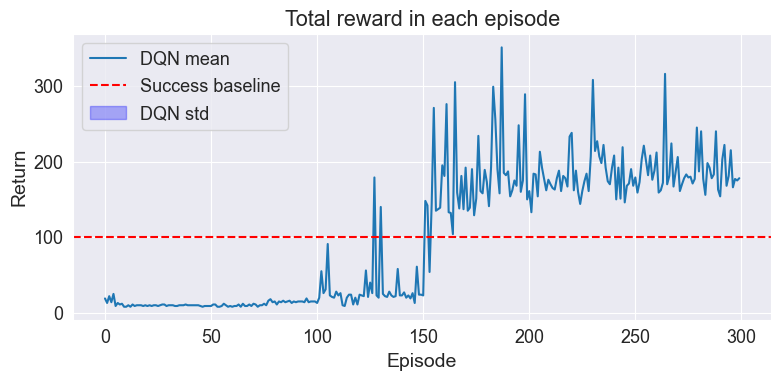

Learning rate: 0.002 
Buffer size: 4500
Update frequency: 25
NN architecture: [4, 128, 128, 2]
Batch size: 70
Exploration: 150
Inverse sensitivity: 150.0


In [55]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.figure(figsize=(8,4),tight_layout=True)
plt.plot(torch.arange(300), means, label="DQN mean")
plt.axhline(100, linestyle="--", color="red", label="Success baseline")
plt.ylabel("Return")
plt.xlabel("Episode")
plt.title(f"Total reward in each episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b', label="DQN std")
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.legend()
#plt.savefig("Q1.3.png", dpi=1000)
plt.show()


print_params()

In [121]:
beta10 = np.loadtxt("beta10.txt")
beta50 = np.loadtxt("beta50.txt")
beta150 = np.loadtxt("beta150.txt")

## Varying beta

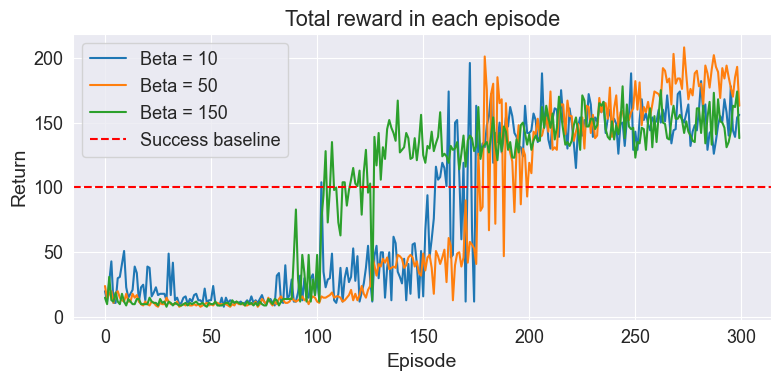

In [123]:
plt.figure(figsize=(8,4),tight_layout=True)
plt.plot(torch.arange(300), beta10, label="Beta = 10")
plt.plot(torch.arange(300), beta50, label="Beta = 50")
plt.plot(torch.arange(300), beta150, label="Beta = 150")
plt.axhline(100, linestyle="--", color="red", label="Success baseline")
plt.ylabel("Return")
plt.xlabel("Episode")
plt.title(f"Total reward in each episode")
#plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b', label="DQN std")
#plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.legend()
plt.savefig("beta_variation.png", dpi=1000)
plt.show()

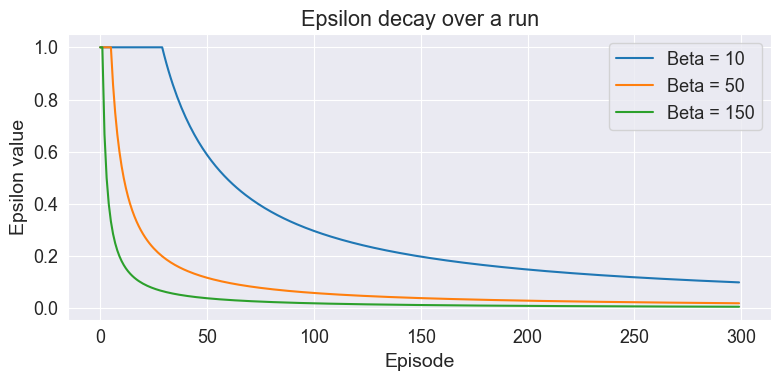

In [129]:
xs = np.arange(300)
ys10 = np.minimum(np.ones(300),300/(10*(xs+1)))
ys50 = np.minimum(np.ones(300),300/(50*(xs+1)))
ys150 = np.minimum(np.ones(300),300/(150*(xs+1)))

plt.figure(figsize=(8,4),tight_layout=True)
plt.plot(xs, ys10, label="Beta = 10")
plt.plot(xs, ys50, label="Beta = 50")
plt.plot(xs, ys150, label="Beta = 150")
plt.xlabel("Episode")
plt.ylabel("Epsilon value")
plt.title("Epsilon decay over a run")
plt.legend()
plt.savefig("epsilon_decay_beta", dpi=1000)
plt.show()


## Varying sigma

In [47]:
s0 = np.loadtxt("sigma0.2.txt")
s5 = np.loadtxt("sigma5.txt")
s25 = np.loadtxt("sigma25.txt")
s150 = np.loadtxt("sigma150.txt")

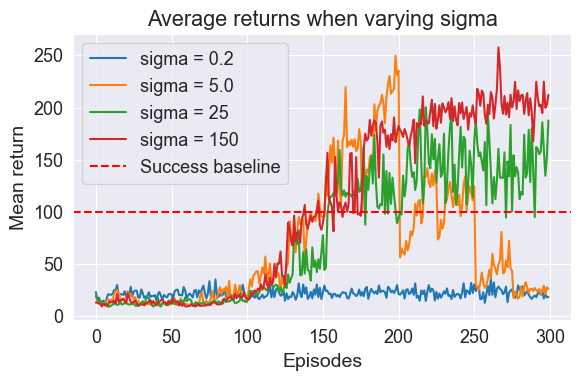

In [50]:
plt.figure(figsize=(6,4),tight_layout=True)
plt.plot(np.arange(300), s0, label="sigma = 0.2")
plt.plot(np.arange(300), s5, label="sigma = 5.0")
plt.plot(np.arange(300), s25, label="sigma = 25")
plt.plot(np.arange(300), s150, label="sigma = 150")
plt.axhline(100, linestyle="--", color="red", label="Success baseline")
plt.xlabel("Episodes")
plt.ylabel("Mean return")
plt.title("Average returns when varying sigma")
plt.legend()
plt.savefig("vary_sigma.png", dpi=1000)
plt.show()

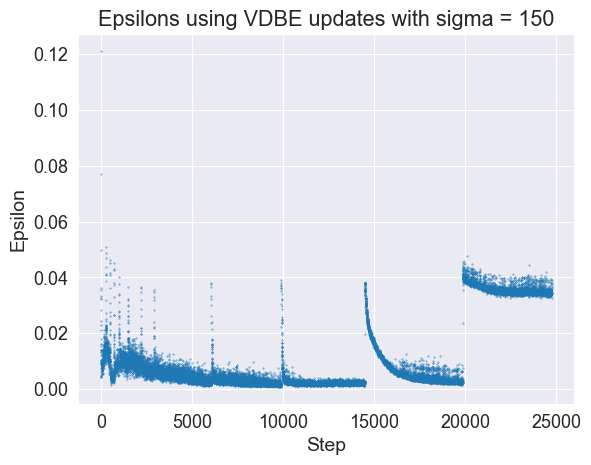

In [51]:
plt.scatter(np.arange(len(epsilons)),epsilons,s=0.1)
plt.xlabel("Step")
plt.ylabel("Epsilon")
plt.title("Epsilons using VDBE updates with sigma = 150")
plt.savefig("epsilon_vdbe.png", dpi=1000)
plt.show()

In [3]:
nets = torch.load("policy_nets.pt")

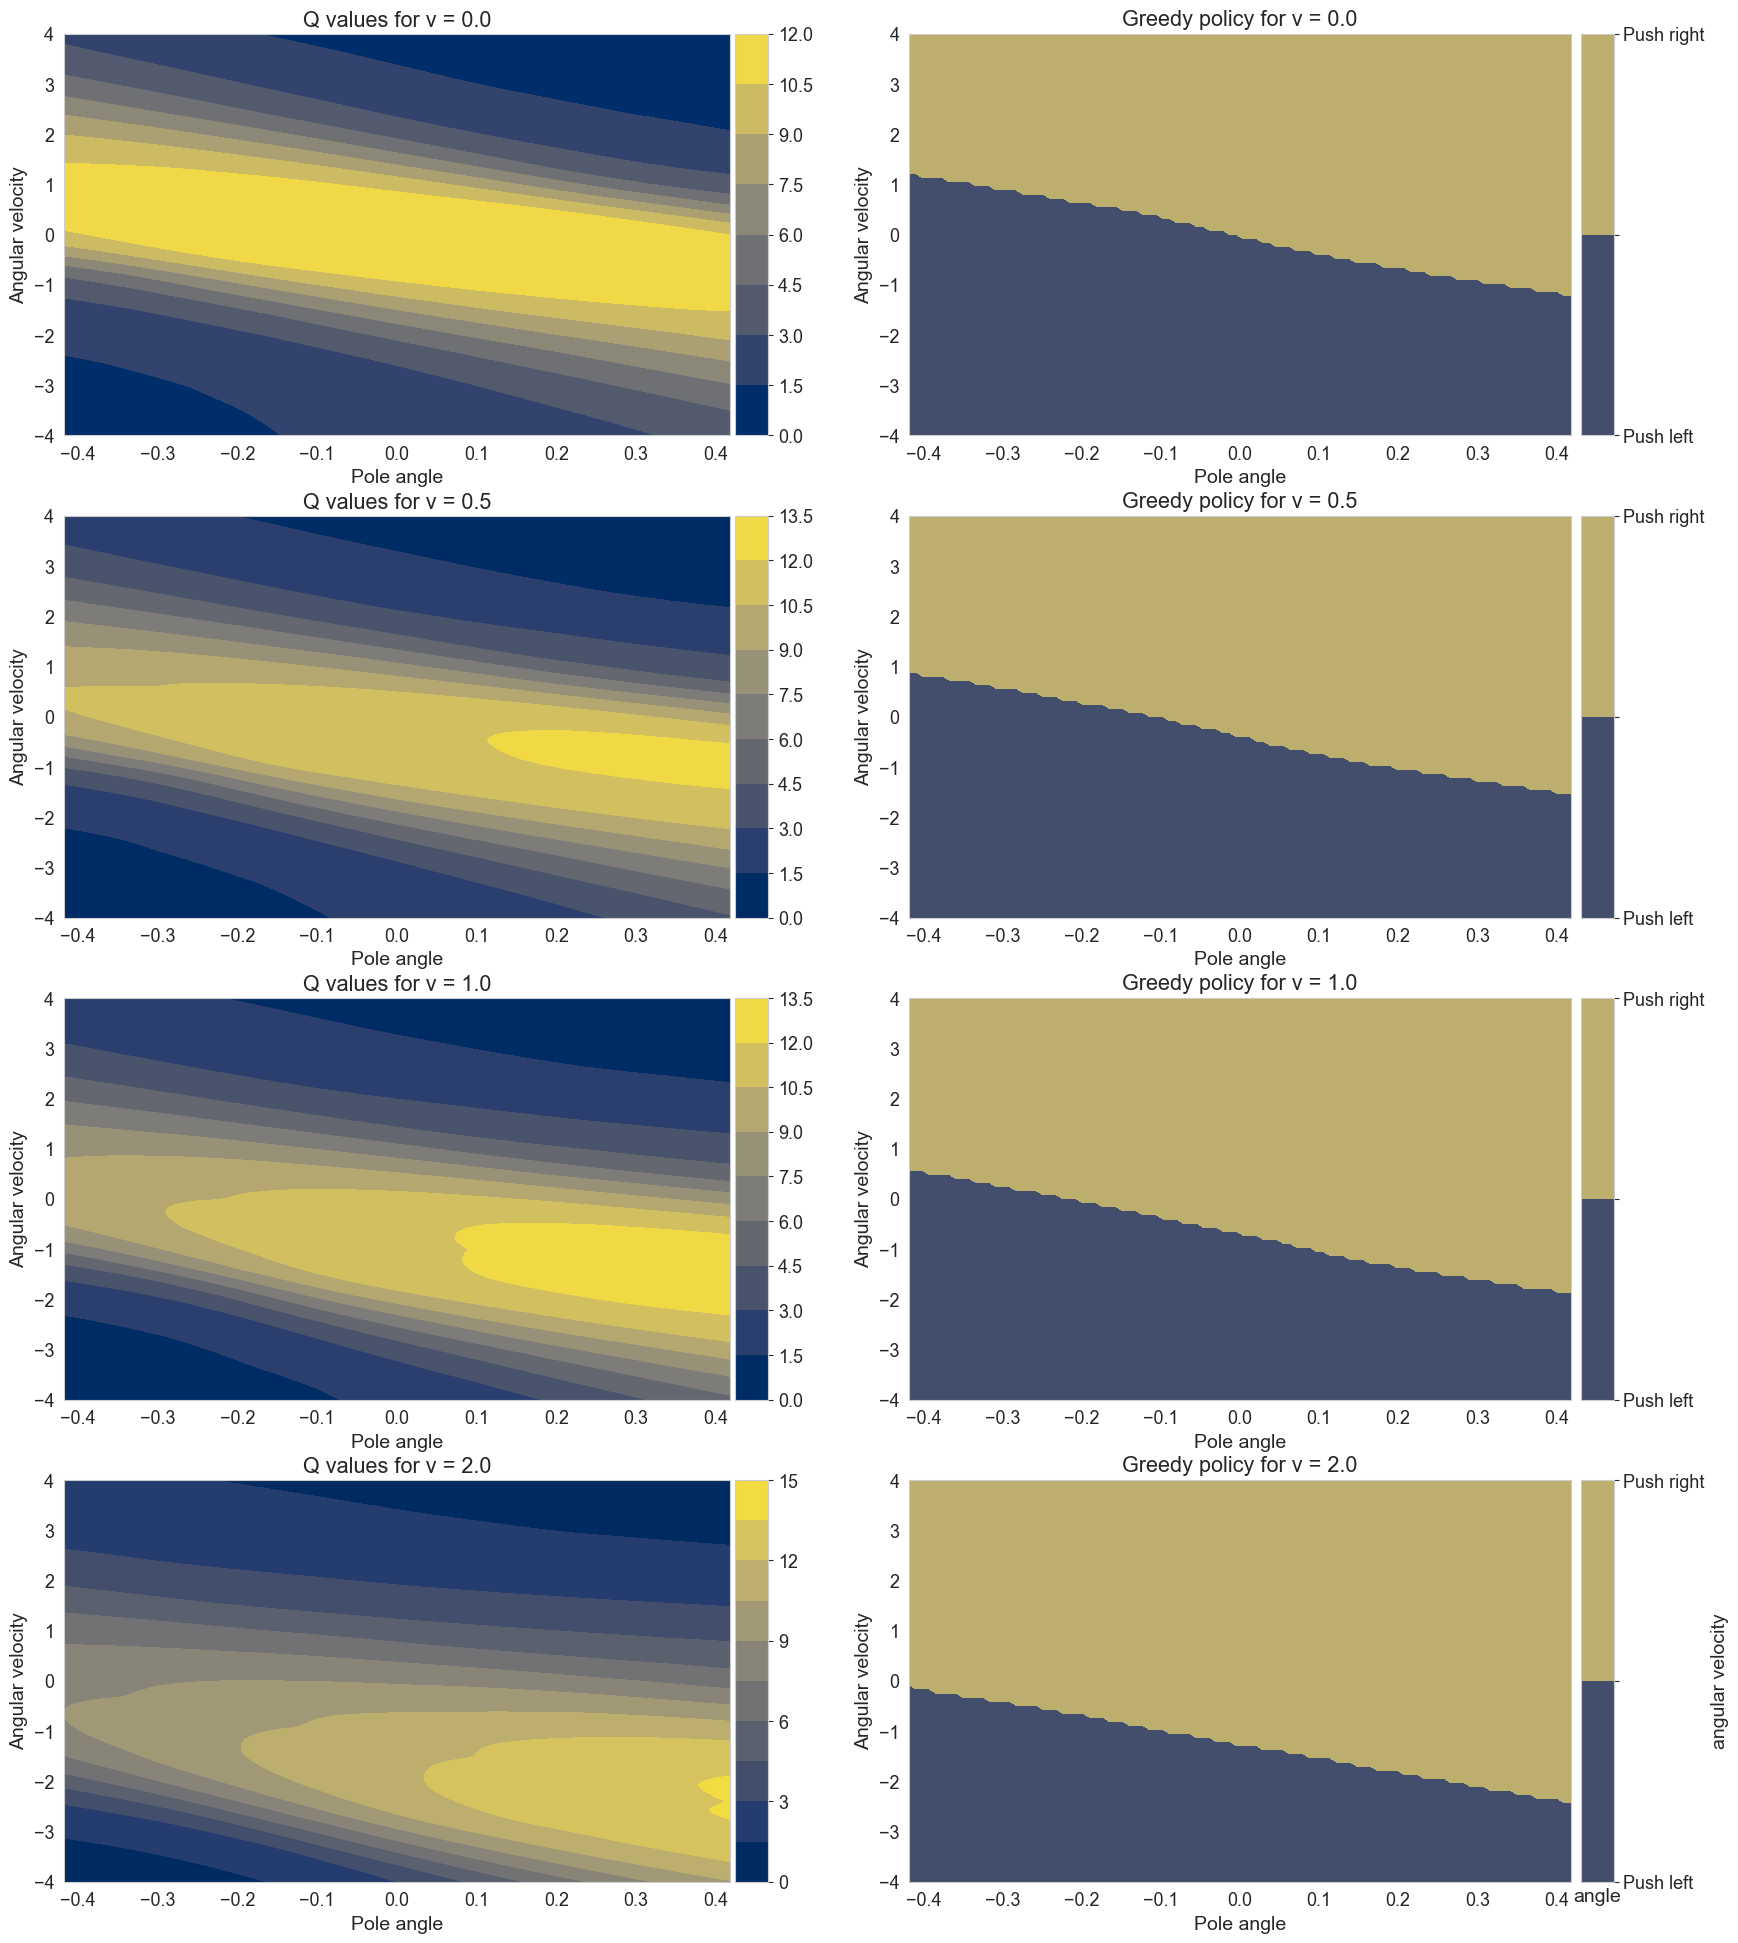

In [4]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

#policy_net = DQN(layers)   # randomly initialised, replace with your trained DQN
q = False    # whether q values or greedy policy is visualised

angle_range = .418 # you may modify this range
omega_range = 4    # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

fig, axs = plt.subplots(4,2,figsize=(20,24))
greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for idx,k in enumerate(np.linspace(0, 2, 5)):
    if idx==3:
        continue
    title1 = f"Q values for v = {k}"
    title2 = f"Greedy policy for v = {k}"
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., float(k), angle, omega])
            q_vals = torch.Tensor([0,0])
            with torch.no_grad():
                for p in nets:
                    q_vals=torch.add(q_vals, p(state), alpha=1/len(nets))
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if idx==4:
        idx-=1
    im=axs[idx,0].contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=10)
    axs[idx,0].set_title(title1)
    axs[idx,0].set_xlabel("Pole angle")
    axs[idx,0].set_ylabel("Angular velocity")
    axs[idx,0].grid(visible=True,color='black', linestyle='-', linewidth=2)
    divider = make_axes_locatable(axs[idx,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    im2 = axs[idx,1].contourf(angles, omegas, policy_array.T, cmap='cividis', levels=1)
    axs[idx,1].set_title(title2)
    axs[idx,1].set_xlabel("Pole angle")
    axs[idx,1].set_ylabel("Angular velocity")
    axs[idx,1].grid(color='black', linestyle='-')
    divider = make_axes_locatable(axs[idx,1])
    cax2 = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(im2, cax=cax2, orientation='vertical')
    cbar.ax.set_yticklabels(['Push left', '', 'Push right'])
            

"""
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis', levels=1)
"""
plt.xlabel("angle")
plt.ylabel("angular velocity")
#plt.colorbar()
#plt.figure(dpi=500)
plt.savefig("Q2.png", dpi=500) 
plt.show()

In [73]:
np.linspace(0,2,5)

array([0. , 0.5, 1. , 1.5, 2. ])

In [65]:
p=nets[8]
p(state)

tensor([-0.1081, -0.0459], grad_fn=<LeakyReluBackward0>)

## DDQN

In [37]:
b = memory.sample(5)
#print(b)
states, actions, nextstate_batch, rewards, dones = (torch.stack(x) for x in zip(*b))
print(policy_net(states))
print(policy_net(states).argmax(1))

tensor([[8.1773, 8.1763],
        [8.3676, 8.3449],
        [7.9867, 8.2263],
        [8.1920, 8.1732],
        [8.1468, 8.1631]], grad_fn=<ReluBackward0>)
tensor([0, 0, 1, 0, 1])


In [10]:
%autoreload

In [31]:
runs_results_ddqn = []
losses = np.empty((NUM_RUNS, num_episodes))

env = gym.make('CartPole-v1', new_step_api=True) # included new_step_api keyword
for run in tqdm.trange(NUM_RUNS):
    #print(f"\nStarting run {run+1} of {NUM_RUNS}")
    policy_net = DQN(layers)  #Neural net layers is hyperparameter
    target_net = DQN(layers)
    update_target(target_net, policy_net)
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learn_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.99)
    memory = ReplayBuffer(mem_size)  #Hyperparameter

    steps_done = 0

    episode_durations = []

    for i_episode in range(num_episodes):
        #if (i_episode+1) % 50 == 0:
            #print("episode ", i_episode+1, "/", num_episodes, end="\r")

        observation = env.reset()  # took away info variable
        state = torch.tensor(observation).float()
        EPSILON = min(1, num_episodes/(beta*(i_episode+1)))
        done = False
        terminated = False
        t = 0
        total_loss = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net, state)

            observation, reward, done, terminated, info = env.step(action)
            """Novelty exploration, but needs to discretise state space
            if EPSILON==1 and i_episode>0:
                info = memory.buffer
                states = (torch.stack(s) for s in zip(*info[0]))
                actions = (torch.stack(a) for a in zip(*info[1]))
                if observation in states and action in actions:
                    reward-=1
            """
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < batch_size:
                transitions = memory.sample(batch_size)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                #mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                hub_loss = cam_loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones, True)
                total_loss += hub_loss.item()
                # Optimize the model
                optimizer.zero_grad()
                #mse_loss.backward()
                hub_loss.backward()
                optimizer.step()
            scheduler.step()
                
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
        losses[run,i_episode] = total_loss/episode_durations[-1]
        # Update the target network, copying all weights and biases in DQN
        if i_episode % update_freq == 0: #Frequency of updating is hyperparameter
            update_target(target_net, policy_net)
    runs_results_ddqn.append(episode_durations)
print('Complete')

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [12:46<00:00, 76.61s/it]

Complete


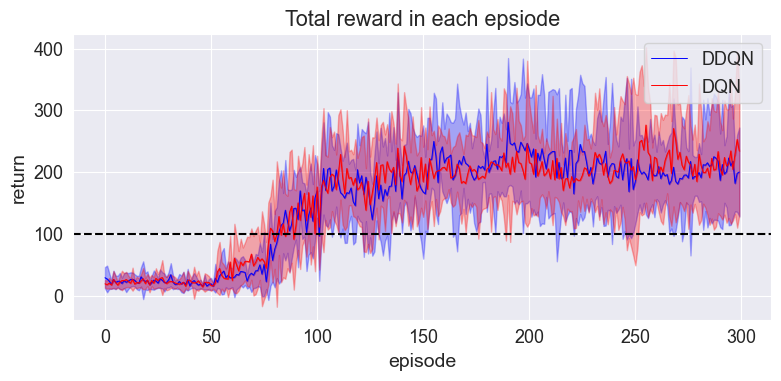

Learning rate: 0.0002 
Buffer size: 4500
Update frequency: 25
NN architecture: [4, 128, 128, 2]
Batch size: 70
Exploration: 10


In [32]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
plt.figure(figsize=(6,4),tight_layout=True)
results_ddqn = torch.tensor(runs_results_ddqn)
means_ddqn = results_ddqn.float().mean(0)
stds_ddqn = results_ddqn.float().std(0)

plt.figure(figsize=(6,4),tight_layout=True)
plt.plot(torch.arange(300), means_ddqn, color="green", label="DDQN")
plt.fill_between(np.arange(300), means_ddqn, means_ddqn+stds_ddqn, alpha=0.3, color='g')
plt.fill_between(np.arange(300), means_ddqn, means_ddqn-stds_ddqn, alpha=0.3, color='g')

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.plot(torch.arange(300), means, label="DQN", color="red")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='r')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='r')

plt.axhline(100, linestyle="--", color="blue")

plt.ylabel("Return")
plt.xlabel("Episode")
plt.title("Learning curves of DQN and DDQN agents")
plt.legend()
plt.savefig("ddqn.png", dpi=1000)
plt.show()

print_params()